In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

In [3]:
df = pd.read_csv('train.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data visualization

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set()

Text(0.5, 1.0, 'Number of siblings/spouses')

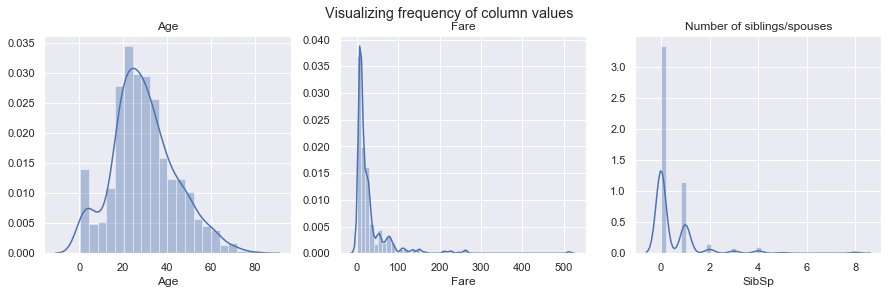

In [6]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(15)
fig.suptitle("Visualizing frequency of column values")
sns.distplot(df['Age'], ax = axs[0]).set_title("Age")
sns.distplot(df['Fare'], ax = axs[1]).set_title("Fare")
sns.distplot(df['SibSp'], ax = axs[2]).set_title("Number of siblings/spouses")

# What do we see from these charts?

Majority of people were between 20 and 40, with most travelling on cheaper fares and with no siblings or spouses.

# Next, let's plot survival rates
(0 means dead, 1 means survived)

Text(0.5, 1.0, 'Percent suvival of female passengers')

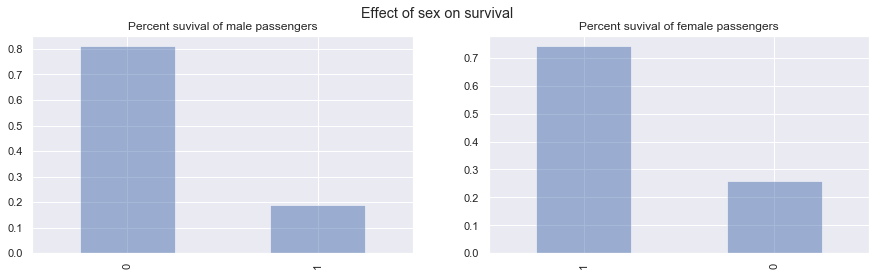

In [7]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle("Effect of sex on survival")
#Effect on survival rate if you are male or female
f1 = df.Survived[df.Sex == "male"].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[0])
f1.set_title("Percent suvival of male passengers")
f2 = df.Survived[df.Sex == "female"].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[1])
f2.set_title("Percent suvival of female passengers")

Here, we can see that female passengers were overwhemingly more likely to survive, with about 75% of them surviving compared to about 18% of male passengers.

Text(0.5, 1.0, 'Percent suvival of adult passengers')

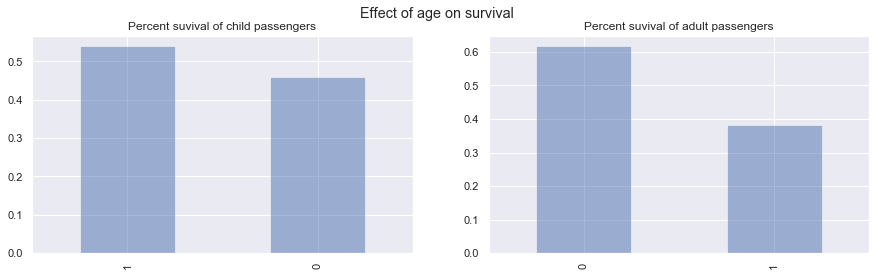

In [8]:
ADULT_AGE = 18 #Cutoff age for adulthood
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle("Effect of age on survival")
#Effect of age on survival rate
f1 = df.Survived[df.Age < ADULT_AGE].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[0])
f1.set_title("Percent suvival of child passengers")
f2 = df.Survived[df.Age > ADULT_AGE].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[1])
f2.set_title("Percent suvival of adult passengers")

Unsurpringly, children also had a higher rate of survival compared to adults, however the difference isn't as drastic as in the male/female graph

Text(0.5, 1.0, 'Percent suvival of richer passengers')

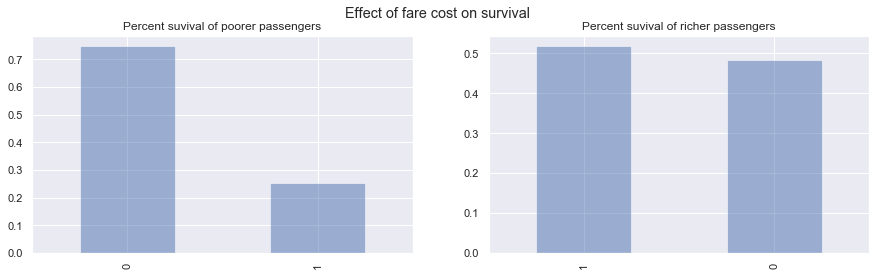

In [9]:
FARE_CUTOFF = df['Fare'].median() #Cutoff fare rate based on median of dataset -> 14.4542
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle("Effect of fare cost on survival")
#Effect of wealth on survival rate
f1 = df.Survived[df.Fare < FARE_CUTOFF].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[0])
f1.set_title("Percent suvival of poorer passengers")
f2 = df.Survived[df.Fare > FARE_CUTOFF].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[1])
f2.set_title("Percent suvival of richer passengers")

Here, using the fare cutoff of the median of the dataset, we can see that the passengers with cheaper tickets were more likely to have died. Interestingly, the passengers with the expensive tickets seem to have an equal chance of dying or living.

This graph assumes that the passengers with more expensive tickets were on average richer than the ones with cheaper tickets.

Text(0.5, 1.0, 'Percent suvival of passengers travelling with siblings/spouses')

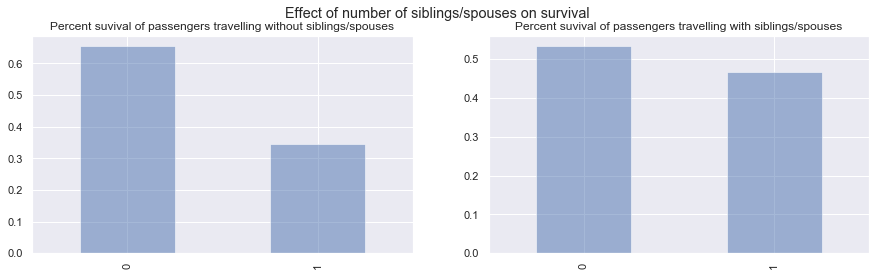

In [10]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle("Effect of number of siblings/spouses on survival")
#Effect of spib/sp on survival rate
f1 = df.Survived[df.SibSp == 0].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[0])
f1.set_title("Percent suvival of passengers travelling without siblings/spouses")
f2 = df.Survived[df.SibSp > 0].value_counts(normalize=True).plot(kind="bar", alpha=0.5, ax = axs[1])
f2.set_title("Percent suvival of passengers travelling with siblings/spouses")

Here we see that passengers travelling alone had a higher death rate compared to those who travelled with others.

# XGBoost algorithm:

In [19]:
from xgboost.sklearn import XGBClassifier as xg
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_svmlight_files
import xgboost as xgb

In [20]:
X, y = df.iloc[:,df.columns != 'Survived'], df.iloc[:,1]

#Converting to DMatrix structure
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Name, Sex, Ticket, Cabin, Embarked

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

In [ ]:
preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))